In [2]:
%matplotlib inline


Computing a Region of Interest (ROI) mask manually
===================================================

This example shows manual steps to create and further modify an ROI spatial
mask. They represent a means for "data folding", i.e., extracting and then
analyzing brain data from a subset of voxels rather than whole brain images.
Example can also help alleviate curse of dimensionality (i.e., statistical
problems that arise in the context of high-dimensional input variables).

We demonstrate how to compute a ROI mask using **T-test** and then how simple
image operations can be used before and after computing ROI to improve the
quality of the computed mask.

These chains of operations are easy to set up using Nilearn and Scipy Python
libraries. Here we give clear guidelines about these steps, starting with
pre-image operations to post-image operations. The main point is that
visualization & results checking be possible at each step.

See also :doc:`plot_extract_rois_smith_atlas` for automatic ROI extraction
of brain connected networks given in 4D image.



Coordinates of the slice we are interested in each direction. We will be
using them for visualization.



In [3]:
# cut in x-direction
sagittal = -25
# cut in y-direction
coronal = -37
# cut in z-direction
axial = -6

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]

Loading the data
----------------
We rely on the Haxby datasets and its experiments to demonstrate the complete
list of operations. Fetching datasets is easy, shipping with Nilearn using a
function named as `fetch_haxby`. The data will then be automatically stored
in a home directory with "nilearn_data" folder in your computer. From which,
we process data using paths of the Nifti images.



In [4]:
# We load data from nilearn by import datasets
from nilearn import datasets

# First, we fetch single subject specific data with haxby datasets: to have
# anatomical image, EPI images and masks images
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])
print('Labels of haxby dataset (text file) is located at: %s' %
      haxby_dataset.session_target[0])

# Second, load the labels stored in a text file into array using pandas
import pandas as pd

session_target = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
# Now, we have the labels and will be useful while computing student's t-test
haxby_labels = session_target['labels']

/Users/gracer/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


First subject anatomical nifti image (3D) located is at: /Users/gracer/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is located at: /Users/gracer/nilearn_data/haxby2001/subj2/bold.nii.gz
Labels of haxby dataset (text file) is located at: /Users/gracer/nilearn_data/haxby2001/subj2/labels.txt


We have the datasets in hand especially paths to the locations. Now, we do
simple pre-processing step called as image smoothing on functional images
and then build a statistical test on smoothed images.



Build a statistical test to find voxels of interest
---------------------------------------------------
**Smoothing**: Functional MRI data have a low signal-to-noise ratio.
When using methods that are not robust to noise, it is useful to apply a
spatial filtering kernel on the data. Such data smoothing is usually applied
using a Gaussian function with 4mm to 12mm full-width at half-maximum (this
is where the FWHM comes from). The function :func:`nilearn.image.smooth_img`
accounts for potential anisotropy in the image affine (i.e., non-indentical
voxel size in all the three dimensions). Analogous to the majority of nilearn
functions, smooth_img function can also use file names as input parameters.



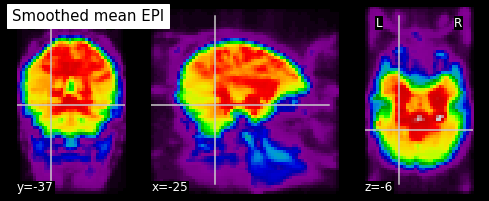

In [5]:
# Smooth the data using image processing module from nilearn
from nilearn import image

# Functional data
fmri_filename = haxby_dataset.func[0]
# smoothing: first argument as functional data filename and smoothing value
# (integer) in second argument. Output returns in Nifti image.
fmri_img = image.smooth_img(fmri_filename, fwhm=6)

# Visualize the mean of the smoothed EPI image using plotting function
# `plot_epi`
from nilearn.plotting import plot_epi

# First, compute the voxel-wise mean of smooth EPI image (first argument) using
# image processing module `image`
mean_img = image.mean_img(fmri_img)
# Second, we visualize the mean image with coordinates positioned manually
plot_epi(mean_img, title='Smoothed mean EPI', cut_coords=cut_coords)

Given the smoothed functional data stored in variable 'fmri_img', we then
select two features of interest with face and house experimental conditions.
The method we will be using is a simple Student's t-test. The below section
gives us brief motivation example about why selecting features in high
dimensional FMRI data setting.



Functional MRI data can be considered "high dimensional" given the p-versus-n
ratio (e.g., p=~20,000-200,000 voxels for n=1000 samples or less). In this
setting, machine-learning algorithms can perform poorly due to the so-called
curse of dimensionality. However, simple means from the realms of classical
statistics can help reducing the number of voxels.



In [6]:
fmri_data = fmri_img.get_data()
# number of voxels being x*y*z, samples in 4th dimension
print(fmri_data.shape)

(40, 64, 64, 1452)


**Selecting features using T-test**: The Student's t-test
(:func:`scipy.stats.ttest_ind`) is an established method to determine whether
two distributions have a different mean value. It can be used to compare voxel
time-series from two different experimental conditions (e.g., when houses or
faces are shown to individuals during brain scanning). If the time-series
distribution is similar in the two conditions, then the voxel is not very
interesting to discriminate the condition.



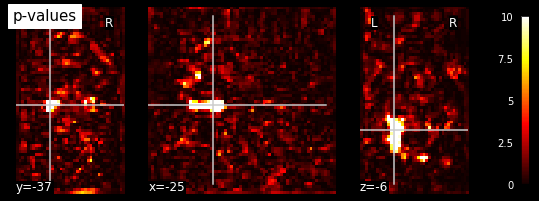

In [7]:
import numpy as np
from scipy import stats

# This test returns p-values that represent probabilities that the two
# time-series were not drawn from the same distribution. The lower the
# p-value, the more discriminative is the voxel in distinguishing the two
# conditions (faces and houses).
_, p_values = stats.ttest_ind(fmri_data[..., haxby_labels == 'face'],
                              fmri_data[..., haxby_labels == 'house'],
                              axis=-1)

# Use a log scale for p-values
log_p_values = -np.log10(p_values)
# NAN values to zero
log_p_values[np.isnan(log_p_values)] = 0.
log_p_values[log_p_values > 10.] = 10.

# Visualize statistical p-values using plotting function `plot_stat_map`
from nilearn.plotting import plot_stat_map

# Before visualizing, we transform the computed p-values to Nifti-like image
# using function `new_img_like` from nilearn.
from nilearn.image import new_img_like

# First argument being a reference image and second argument should be p-values
# data to convert to a new image as output. This new image will have same header
# information as reference image.
log_p_values_img = new_img_like(fmri_img, log_p_values)

# Now, we visualize log p-values image on functional mean image as background
# with coordinates given manually and colorbar on the right side of plot (by
# default colorbar=True)
plot_stat_map(log_p_values_img, mean_img,
              title="p-values", cut_coords=cut_coords)

**Selecting features using f_classif**: Feature selection method is also
available in the scikit-learn Python package, where it has been extended to
several classes, using the `sklearn.feature_selection.f_classif` function.



Build a mask from this statistical map (Improving the quality of the mask)
--------------------------------------------------------------------------
**Thresholding** - We build the t-map to have better representation of voxels
of interest and voxels with lower p-values correspond to the most intense
voxels. This can be done easily by applying a threshold to a t-map data in
array.



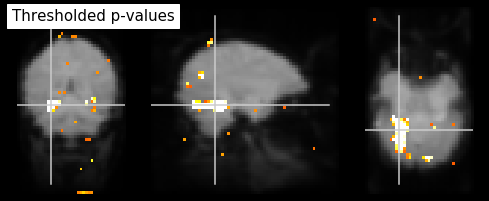

In [8]:
# Note that we use log p-values data; we force values below 5 to 0 by
# thresholding.
log_p_values[log_p_values < 5] = 0

# Visualize the reduced voxels of interest using statistical image plotting
# function. As shown above, we first transform data in array to Nifti image.
log_p_values_img = new_img_like(fmri_img, log_p_values)

# Now, visualizing the created log p-values to image without colorbar and
# without Left - 'L', Right - 'R' annotation
plot_stat_map(log_p_values_img, mean_img,
              title='Thresholded p-values', annotate=False,
              colorbar=False, cut_coords=cut_coords)

We can post-process the results obtained with simple operations such as mask
intersection and dilation to regularize the mask definition. The idea of using
these operations are to have more compact or sparser blobs.



**Binarization** and **Intersection** with Ventral Temporal (VT) mask - We
now want to restrict our investigation to the VT area. The corresponding
spatial mask is provided in haxby_dataset.mask_vt. We want to compute the
intersection of this provided mask with our self-computed mask.



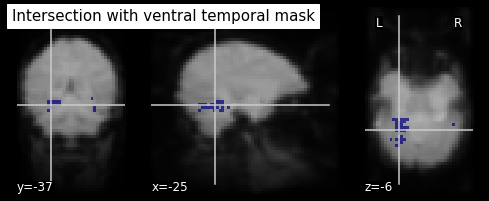

In [9]:
# self-computed mask
bin_p_values = (log_p_values != 0)
# VT mask
mask_vt_filename = haxby_dataset.mask_vt[0]

# The first step is to load VT mask and same time convert data type
# numbers to boolean type
from nilearn.image import load_img

vt = load_img(mask_vt_filename).get_data().astype(bool)

# We can then use a logical "and" operation - numpy.logical_and - to keep only
# voxels that have been selected in both masks. In neuroimaging jargon, this
# is called an "AND conjunction". We use already imported numpy as np
bin_p_values_and_vt = np.logical_and(bin_p_values, vt)

# Visualizing the mask intersection results using plotting function `plot_roi`,
# a function which can be used for visualizing target specific voxels.
from nilearn.plotting import plot_roi, show

# First, we create new image type of binarized and intersected mask (second
# argument) and use this created Nifti image type in visualization. Binarized
# values in data type boolean should be converted to int data type at the same
# time. Otherwise, an error will be raised
bin_p_values_and_vt_img = new_img_like(fmri_img,
                                       bin_p_values_and_vt.astype(np.int))
# Visualizing goes here with background as computed mean of functional images
plot_roi(bin_p_values_and_vt_img, mean_img, cut_coords=cut_coords,
         title='Intersection with ventral temporal mask')

**Dilation** - Thresholded functional brain images often contain scattered
voxels across the brain. To consolidate such brain images towards more compact
shapes, we use a `morphological dilation
<http://en.wikipedia.org/wiki/Dilation_(morphology)>`_. This is a common step
to be sure not to forget voxels located on the edge of a ROI. In other words,
such operations can fill "holes" in masked voxel representations.



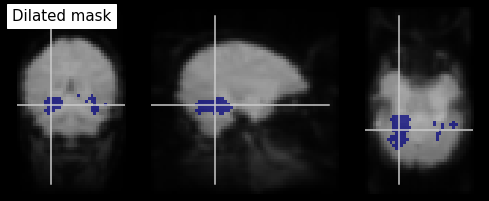

In [10]:
# We use ndimage function from scipy Python library for mask dilation
from scipy import ndimage

# Input here is a binarized and intersected mask data from previous section
dil_bin_p_values_and_vt = ndimage.binary_dilation(bin_p_values_and_vt)

# Now, we visualize the same using `plot_roi` with data being converted to Nifti
# image. In all new image like, reference image is the same but second argument
# varies with data specific
dil_bin_p_values_and_vt_img = new_img_like(
    fmri_img,
    dil_bin_p_values_and_vt.astype(np.int))
# Visualization goes here without 'L', 'R' annotation and coordinates being the
# same
plot_roi(dil_bin_p_values_and_vt_img, mean_img,
         title='Dilated mask', cut_coords=cut_coords,
         annotate=False)

Finally, we end with splitting the connected ROIs to two hemispheres into two
separate regions (ROIs). The function `scipy.ndimage.label` from the scipy
Python library.



**Identification of connected components** - The function
:func:`scipy.ndimage.label` from the scipy Python library identifies
immediately neighboring voxels in our voxels mask. It assigns a separate
integer label to each one of them.



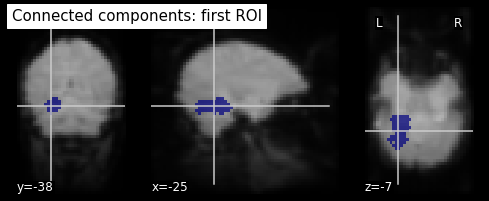

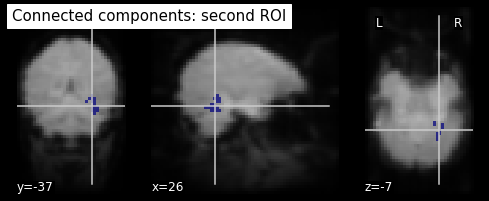

In [11]:
labels, n_labels = ndimage.label(dil_bin_p_values_and_vt)
# we take first roi data with labels assigned as integer 1
first_roi_data = (labels == 5).astype(np.int)
# Similarly, second roi data is assigned as integer 2
second_roi_data = (labels == 3).astype(np.int)
# Visualizing the connected components
# First, we create a Nifti image type from first roi data in a array
first_roi_img = new_img_like(fmri_img, first_roi_data)
# Then, visualize the same created Nifti image in first argument and mean of
# functional images as background (second argument), cut_coords is default now
# and coordinates are selected automatically pointed exactly on the roi data
plot_roi(first_roi_img, mean_img, title='Connected components: first ROI')
# we do the same for second roi data
second_roi_img = new_img_like(fmri_img, second_roi_data)
# Visualization goes here with second roi image and cut_coords are default with
# coordinates selected automatically pointed on the data
plot_roi(second_roi_img, mean_img, title='Connected components: second ROI')

Use the new ROIs, to extract data maps in both ROIs



In [12]:
# We extract data from ROIs using nilearn's NiftiLabelsMasker
from nilearn.input_data import NiftiLabelsMasker

# Before data extraction, we convert an array labels to Nifti like image. All
# inputs to NiftiLabelsMasker must be Nifti-like images or filename to Nifti
# images. We use the same reference image as used above in previous sections
labels_img = new_img_like(fmri_img, labels)
# First, initialize masker with parameters suited for data extraction using
# labels as input image, resampling_target is None as affine, shape/size is same
# for all the data used here, time series signal processing parameters
# standardize and detrend are set to False
masker = NiftiLabelsMasker(labels_img, resampling_target=None,
                           standardize=False, detrend=False)
# After initialization of masker object, we call fit() for preparing labels_img
# data according to given parameters
masker.fit()
# Preparing for data extraction: setting number of conditions, size, etc from
# haxby dataset
condition_names = haxby_labels.unique()
n_cond_img = fmri_data[..., haxby_labels == 'house'].shape[-1]
n_conds = len(condition_names)

X1, X2 = np.zeros((n_cond_img, n_conds)), np.zeros((n_cond_img, n_conds))
# Gathering data for each condition and then use transformer from masker
# object transform() on each data. The transformer extracts data in condition
# maps where the target regions are specified by labels images
for i, cond in enumerate(condition_names):
    cond_maps = new_img_like(
        fmri_img, fmri_data[..., haxby_labels == cond][..., :n_cond_img])
    mask_data = masker.transform(cond_maps)
    X1[:, i], X2[:, i] = mask_data[:, 0], mask_data[:, 1]
condition_names[np.where(condition_names == 'scrambledpix')] = 'scrambled'

save the ROI 'atlas' to a Nifti file



In [13]:
new_img_like(fmri_img, labels).to_filename('mask_atlas.nii.gz')

Plot the average in the different condition names



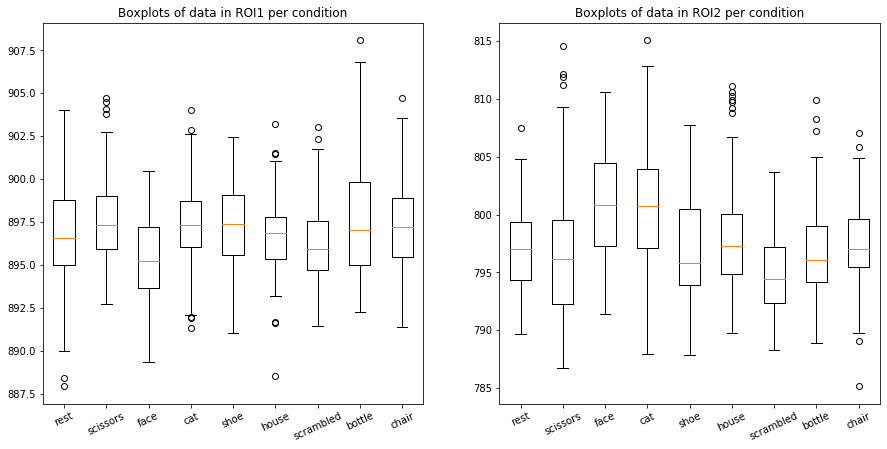

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
for i in np.arange(2):
    plt.subplot(1, 2, i + 1)
    plt.boxplot(X1 if i == 0 else X2)
    plt.xticks(np.arange(len(condition_names)) + 1, condition_names,
               rotation=25)
    plt.title('Boxplots of data in ROI%i per condition' % (i + 1))

show()